In [115]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [116]:
df=pd.read_csv('csv_session2.csv', index_col=0, parse_dates=True)

In [117]:
df.index.to_period("D")

PeriodIndex(['2016-02-24', '2016-02-24', '2016-02-24', '2016-02-24',
             '2016-02-24', '2016-02-24', '2016-02-24', '2016-02-24',
             '2016-02-24', '2016-02-24',
             ...
             '2016-02-29', '2016-02-29', '2016-02-29', '2016-02-29',
             '2016-02-29', '2016-02-29', '2016-02-29', '2016-02-29',
             '2016-02-29', '2016-02-29'],
            dtype='period[D]', name='Timestamp (GMT)', length=6844, freq='D')

In [118]:
df

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
Timestamp (GMT),,,,
2016-02-24 15:53:00,NaN,NaN,85.0,72.0
2016-02-24 15:54:00,61441.0,61441.0,90.0,123.0
2016-02-24 15:55:00,153.0,51.0,91.0,153.0
2016-02-24 15:56:00,153.0,48.0,92.0,136.0
2016-02-24 15:57:00,153.0,46.0,NaN,NaN
...,...,...,...,...
2016-02-29 09:52:00,NaN,NaN,NaN,NaN
2016-02-29 09:53:00,NaN,NaN,NaN,NaN
2016-02-29 09:54:00,NaN,NaN,NaN,NaN


In [119]:
#data preprocessing
df = df.dropna()
df=  df.loc[df['Lifetouch Heart Rate'] <= 200]
df=  df.loc[df['Oximeter SpO2'] >= 40]

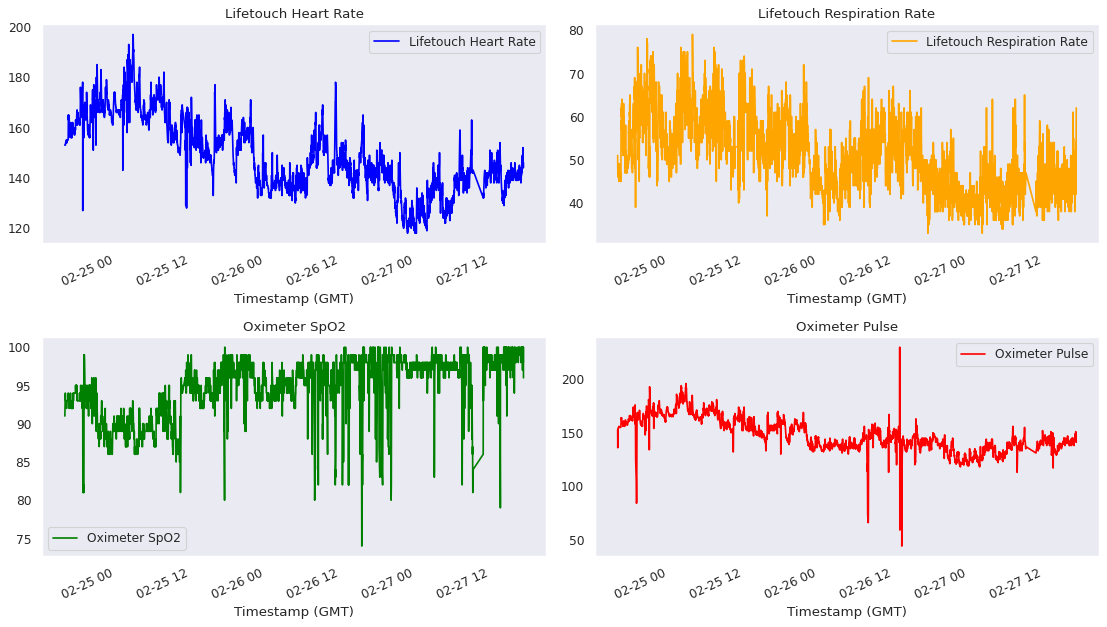

In [120]:
color_list = [
    "blue",
    "orange",
    "green",
    "red",
    "purple"
]


def Visualize(data):
    features= list(df.select_dtypes(include=[np.number]).columns.values)
    feature_size=len(features)
    fig, axes = plt.subplots(
        nrows=int(np.ceil(feature_size/2)), ncols=2, figsize=(14, feature_size*2), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(feature_size):
        key = features[i]
        c = color_list[i % (len(color_list))]
        t_data = data[key]
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{}".format(key),
            rot=25,
        )
        ax.legend([key])
    plt.tight_layout()


Visualize(df)

In [121]:
from statsmodels.tsa.stattools import adfuller
adfuller_test = adfuller(df['Oximeter SpO2'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -3.7564207451361344
p-value: 0.0033860176386733263


Null Hypothesis - Series possesses a unit root and hence is not stationary

Alternate Hypothesis - Series is stationary

In [122]:
for i in range(len(df.columns)):
  result = adfuller(df[df.columns[i]])

  if result[1] > 0.05 :
    print('{} - Series is not Stationary'.format(df.columns[i]))
  else:
    print('{} - Series is Stationary'.format(df.columns[i]))

Lifetouch Heart Rate - Series is not Stationary
Lifetouch Respiration Rate - Series is Stationary
Oximeter SpO2 - Series is Stationary
Oximeter Pulse - Series is not Stationary


**make fields stationary**

In [123]:
df = df.diff().dropna()

**Confirm stationary**

In [124]:
for i in range(len(df.columns)):
  result = adfuller(df[df.columns[i]])

  if result[1] > 0.05 :
    print('{} - Series is not Stationary'.format(df.columns[i]))
  else:
    print('{} - Series is Stationary'.format(df.columns[i]))

Lifetouch Heart Rate - Series is Stationary
Lifetouch Respiration Rate - Series is Stationary
Oximeter SpO2 - Series is Stationary
Oximeter Pulse - Series is Stationary


In [125]:
df_input=df[['Lifetouch Heart Rate', 'Lifetouch Respiration Rate','Oximeter SpO2', 'Oximeter Pulse']]

In [126]:
df_input

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
Timestamp (GMT),,,,
2016-02-24 15:56:00,0.0,-3.0,1.0,-17.0
2016-02-24 15:59:00,0.0,-2.0,2.0,17.0
2016-02-24 16:00:00,0.0,3.0,0.0,1.0
2016-02-24 16:01:00,1.0,-1.0,-1.0,0.0
2016-02-24 16:02:00,0.0,1.0,0.0,1.0
...,...,...,...,...
2016-02-27 17:19:00,-3.0,4.0,0.0,-2.0
2016-02-27 17:20:00,-2.0,-12.0,-1.0,-2.0
2016-02-27 17:21:00,-3.0,11.0,-1.0,-1.0


In [127]:
#first 90%
df_train = df_input[:int(0.9*(len(df_input)))]
#next 10%
df_test = df_input[int(0.9*(len(df_input))):]

In [128]:
df_train.shape

(3665, 4)

In [129]:
df_test.shape

(408, 4)

![link text](https://wikimedia.org/api/rest_v1/media/math/render/svg/d79bead4e9192d7fe2470a7936e4623e9ff252e1)

![link text](https://wikimedia.org/api/rest_v1/media/math/render/svg/d88ac4002c0641b2e93fb6d35f961ea63352b6a9)

In [130]:
model = VAR(df_train)
results_aic = []
for p in range(1,10):
  results = model.fit(p)
  results_aic.append(results.aic)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


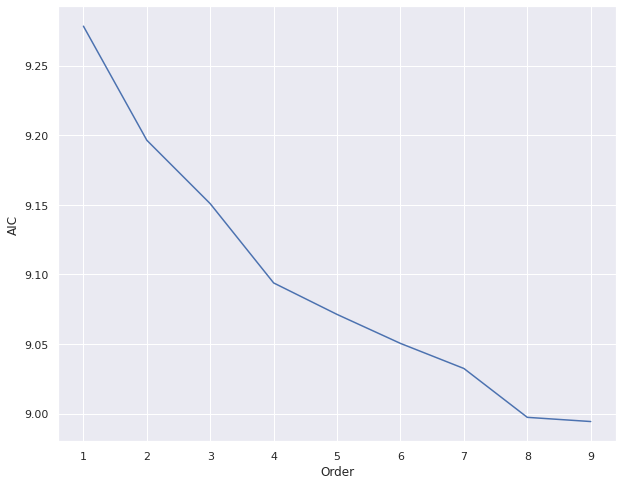

In [131]:
import seaborn as sns
sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [132]:
model.select_order(10).summary()

,AIC,BIC,FPE,HQIC
0,9.470,9.477,1.296e+04,9.472
1,9.285,9.319,1.078e+04,9.297
2,9.205,9.266,9945.,9.227
3,9.158,9.246,9492.,9.190
4,9.100,9.216*,8958.,9.141
5,9.077,9.219,8748.,9.127
6,9.055,9.224,8558.,9.115
7,9.036,9.233,8397.,9.106
8,8.999,9.223,8098.,9.079*
9,8.995,9.247,8066.,9.085


In [133]:
results = model.fit(9)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 09, Jun, 2021
Time:                     13:33:52
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    9.24552
Nobs:                     3656.00    HQIC:                   9.08380
Log likelihood:          -37044.3    FPE:                    8057.57
AIC:                      8.99436    Det(Omega_mle):         7739.47
--------------------------------------------------------------------
Results for equation Lifetouch Heart Rate
                                   coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------
const                                -0.004632         0.047838           -0.097           0.923
L1.Lifetouch Heart Rate              -0.203926         0.016987          -12.0

In [134]:
def plot_results(real, predicted):
    
    # plot
    plt.figure(figsize=(25,10))
    plt.plot(real[:32], label='real')
    plt.plot(predicted[:32], color='red', label='prediction')
    plt.legend(loc="upper right")
    plt.show()
    
    # plot
    plt.figure(figsize=(25,10))
    plt.plot(real, label='real')
    plt.plot(predicted, color='red', label='prediction')
    plt.legend(loc="upper right")
    plt.show()

In [135]:
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import math
from math import sqrt
def run_forecast(lag_nr):
    
    print("Forecast for lag: ", lag_nr)

    values = df.values
    train = df_train
    test = df_test
    history = train.copy(deep=True)
    predictions = list()

    for t in range(len(test)):
        model = VAR(history)        
        results = model.fit(lag_nr)
        yhat = results.forecast(history.values[-lag_nr:], 1)[0][0]       
        predictions.append(yhat)
        history = history.append(test[t:t+1])
    
    y_actual = test.values[:, 0]
    rmse = sqrt(mean_squared_error(y_actual, predictions))
    print('MSE: %.3f' % rmse)
    print("MAE: ",  mean_absolute_error(y_actual, predictions))

    plot_results(y_actual, predictions)
    
    return rmse

Forecast for lag:  9


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

MSE: 2.125
MAE:  1.5977602557018218


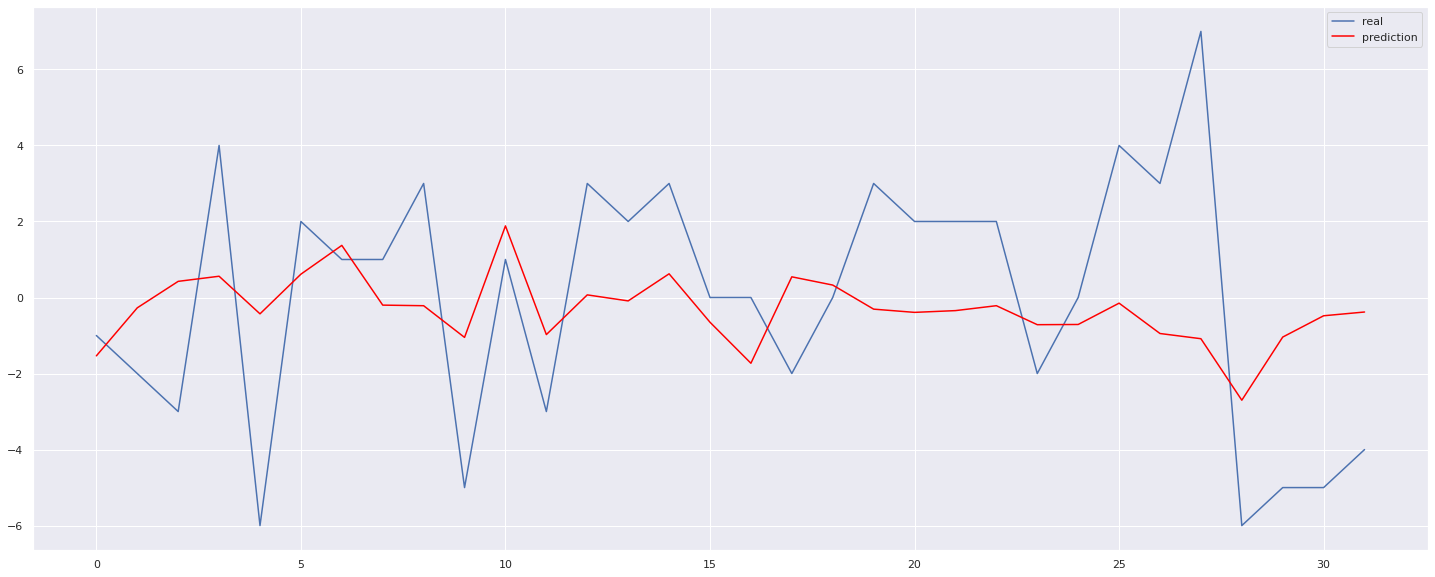

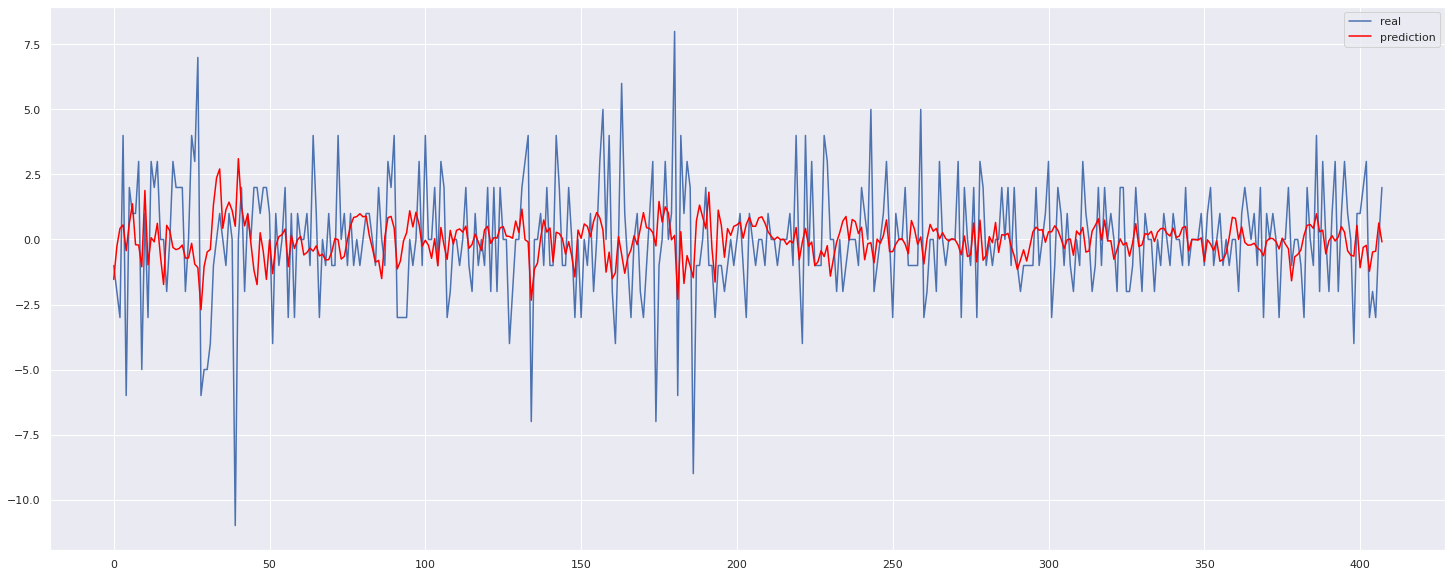

2.1254279506558458

In [136]:

run_forecast(9)